# **ΣΤΟΙΧΕΙΑ**
ΟΡΕΣΤ ΜΟΥΤΣΑΙ - 1115201900120 - ΠΡΟΠΤΥΧΙΑΚΟΣ

# **Imports**

In [ ]:
# Import required libraries and packages

import re
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from wordcloud import WordCloud
from PIL import Image, ImageDraw, ImageFont
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import unicodedata
import copy

# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')

# Set a random seed for reproducibility

SEED = 21
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Directories

input_dir = ('/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/')
output_dir = ('/kaggle/working/')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Obtain the DataSet

In [2]:
# Download the embedding, keeping only the desired dimensions

if not os.path.exists("glove.twitter.27B.200d.txt"):
    !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
    !unzip glove.twitter.27B.zip

    !rm glove.twitter.27B.25d.txt
    !rm glove.twitter.27B.50d.txt
    !rm glove.twitter.27B.100d.txt
else:
    print("glove.twitter.27B.200d.txt already exists.")

--2025-05-04 22:27:44--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-05-04 22:27:44--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.00MB/s    in 4m 44s  

2025-05-04 22:32:29 (5.10 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [3]:
# Load the data

train_df = pd.read_csv(input_dir + 'train_dataset.csv')
val_df = pd.read_csv(input_dir + 'val_dataset.csv')
test_df = pd.read_csv(input_dir + 'test_dataset.csv')

# DATA ANALYSIS - BEFORE PRE-PROCESSING

In [4]:
# Print a sample of training data before pre-processing

pd.set_option('display.max_colwidth', None)
train_df.head(10)

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely bin in cobham!!! where they found is literally minutes from my house! feel sick now!",0
2,190139,"I end up &quot;dog dialing&quot; sumtimes. What's dog dialing, u ask?My dogs will walk across my phone &amp; end up calling someone. aka &quot;dog dialing&quot;!",1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today, but looks like I have to make another trip into town",0
5,130560,says plurk karma finally reached the 50s. still no heartsy smileys. boo. http://plurk.com/p/z2x3y,0
6,121871,"Good to hear it @Arth This is a bit more, but a la four tet Do you know Free Rotation festival? Am thinking ... Ã¢â¢Â« http://blip.fm/~7hcvo",1
7,86813,"@davorg in that case im gonna start tweeting about nymphomanic pub owners who like to cook, well worth a shot, eh",1
8,197517,"@belunyc its alright love, how are you?",1
9,6937,@brightondoll haha that has to be the best analogy ever. mogwai to gremlin. love it. i love gizmo and the gremlins movies,1


In [5]:
# Check if the database classes are evenly balanced

print(train_df['Label'].value_counts())
print(val_df['Label'].value_counts())

Label
1    74196
0    74192
Name: count, dtype: int64
Label
1    21199
0    21197
Name: count, dtype: int64


In [6]:
# Get The Most Common Words And The Number Of Unique And Total Words Before Preprocessing

print("ANALYSING DATA BEFORE PRE-PROCESSING THE DATASET\n")

def get_most_common_words(text_series, top_n=10, exclude_stopwords=True):
    all_words = []
    stop_words = set(stopwords.words('english'))

    for text in text_series.dropna():
        tokens = word_tokenize(text)

        if exclude_stopwords:
            words = [word for word in tokens if word.lower() not in stop_words]
        else:
            words = tokens

        all_words.extend(words)

    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

def count_words(text_series, exclude_stopwords=True, unique=True):
    all_words = []
    stop_words = set(stopwords.words('english'))

    for text in text_series.dropna():
        tokens = word_tokenize(text)

        if exclude_stopwords:
            words = [word for word in tokens if word.lower() not in stop_words]
        else:
            words = tokens

        all_words.extend(words)

    return len(set(all_words)) if unique else len(all_words)

common_words = get_most_common_words(train_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

print("For the training dataset:\n", df.to_string(index=False), "\n")

common_words = get_most_common_words(val_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
print("For the validation dataset:\n", df.to_string(index=False), "\n")

common_words = get_most_common_words(test_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
print("For the testing dataset:\n", df.to_string(index=False), "\n")

vocab_size = count_words(train_df['Text'], exclude_stopwords=False, unique=True)
print(f"Unique word count in the training dataset: {vocab_size}")

vocab_size = count_words(train_df['Text'], exclude_stopwords=False, unique=False)
print(f"Total word count in the training dataset: {vocab_size}\n")

vocab_size = count_words(val_df['Text'],exclude_stopwords=False, unique=True)
print(f"Unique word count in the validation dataset: {vocab_size}")

vocab_size = count_words(val_df['Text'],exclude_stopwords=False, unique=False)
print(f"Total word count in the validation dataset: {vocab_size}\n")

vocab_size = count_words(test_df['Text'], exclude_stopwords=False, unique=True)
print(f"Unique word count in the testing dataset: {vocab_size}")

vocab_size = count_words(test_df['Text'],exclude_stopwords=False, unique=False)
print(f"Total word count in the testing dataset: {vocab_size}\n")

ANALYSING DATA BEFORE PRE-PROCESSING THE DATASET

For the training dataset:
 Word  Frequency
   !      85636
   @      74891
   .      74742
   I      60927
  to      51952
 the      45926
   ,      45383
   a      34473
   i      28200
 and      26513 

For the validation dataset:
 Word  Frequency
   !      24852
   .      21913
   @      21508
   I      17517
  to      14640
 the      13084
   ,      12933
   a       9886
   i       8117
  my       7624 

For the testing dataset:
 Word  Frequency
   !      12425
   .      10707
   @      10703
   I       8564
  to       7495
 the       6670
   ,       6646
   a       5009
   i       3941
  my       3866 

Unique word count in the training dataset: 161429
Total word count in the training dataset: 2453768

Unique word count in the validation dataset: 64533
Total word count in the validation dataset: 702940

Unique word count in the testing dataset: 39033
Total word count in the testing dataset: 353018



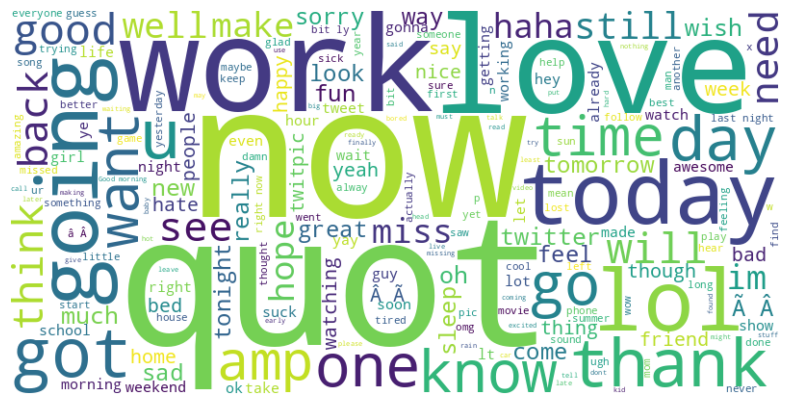

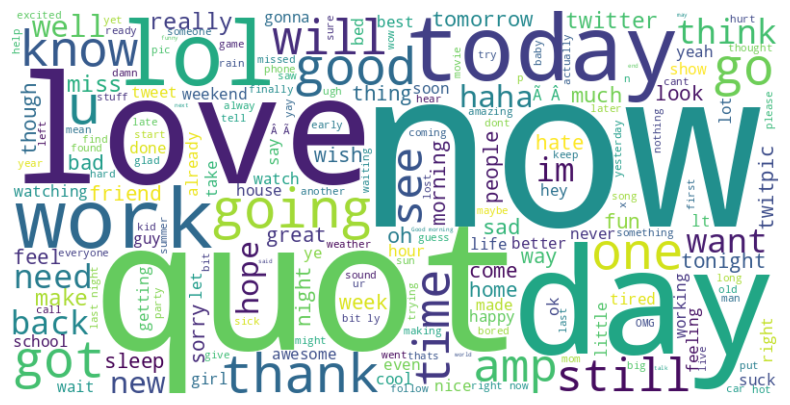

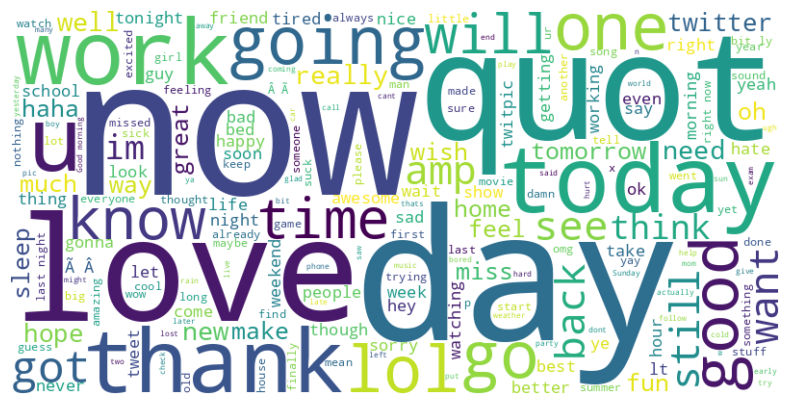

In [7]:
# Generate Word Cloud Before Preprocessing

text = " ".join(str(word) for word in train_df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'train_word_cloud_before.png')
plt.show()

text = " ".join(str(word) for word in val_df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'val_word_cloud_before.png')
plt.show()

text = " ".join(str(word) for word in test_df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'test_word_cloud_before.png')
plt.show()

# **DATA PRE-PROCESSING**

Steps:
1. Remove non Ascii characters
2. Reduce repeated characters(of more than 2) to only two of them
4. Remove usernames
5. Replace numbers with tag &lt;num&gt;
6. Lowercase, De-Accent, Tokenize (similar to Gensim's simple pre-processing)

In [8]:
# Remove Non-Ascii characters

def remove_non_ascii_characters(text):
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    return cleaned_text

train_df['Text'] = train_df['Text'].apply(remove_non_ascii_characters)
val_df['Text'] = val_df['Text'].apply(remove_non_ascii_characters)
test_df['Text'] = test_df['Text'].apply(remove_non_ascii_characters)

In [9]:
# Replace 3 or more repeated characters with only 2

def reduce_repeated_characters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

train_df['Text'] = train_df['Text'].apply(reduce_repeated_characters)
val_df['Text'] = val_df['Text'].apply(reduce_repeated_characters)
test_df['Text'] = test_df['Text'].apply(reduce_repeated_characters)

In [10]:
# Remove Usernames

def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

train_df['Text'] = train_df['Text'].apply(remove_usernames)
val_df['Text'] = val_df['Text'].apply(remove_usernames)
test_df['Text'] = test_df['Text'].apply(remove_usernames)

In [11]:
# Replace Numbers with <number> Tag
def replace_numbers(text):
    return re.sub(r'-?\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b', '<number>', text)

train_df['Text'] = train_df['Text'].apply(replace_numbers)
val_df['Text'] = val_df['Text'].apply(replace_numbers)
test_df['Text'] = test_df['Text'].apply(replace_numbers)

In [12]:
# Tokenizer, Lowercase, De-Accent, Split at non-alphabetic characters, Filter by length(2), preserving the Tag <number> as is

def tokenizer(text, deacc=True, min_len=2, max_len=15):
    tokens = []
    for part in re.split(r'(<number>)', text):
        if part == '<number>':
            tokens.append(part)
        else:
            part = part.lower()
            if deacc:
                part = unicodedata.normalize('NFKD', part).encode('ascii', 'ignore').decode('ascii')
            words = re.findall(r'[a-z]+', part)
            tokens.extend([word for word in words if min_len <= len(word) <= max_len])
    return tokens

train_df['Text'] = train_df['Text'].apply(tokenizer)
val_df['Text'] = val_df['Text'].apply(tokenizer)
test_df['Text'] = test_df['Text'].apply(tokenizer)

In [13]:
# Count how many words bear the tag <number>

train_num_count = sum(train_df['Text'].apply(lambda tokens: tokens.count('<number>')))
print(train_num_count)

val_num_count = sum(val_df['Text'].apply(lambda tokens: tokens.count('<number>')))
print(val_num_count)

test_num_count = sum(test_df['Text'].apply(lambda tokens: tokens.count('<number>')))
print(test_num_count)

20786
5884
2888


# DATA ANALYSIS - AFTER PRE-PROCESSING

In [14]:
# Print a sample of training data after pre-processing

pd.set_option('display.max_colwidth', None)
train_df.head(10)

,ID,Text,Label
0,189385,"[dude, so, bummed, ur, leaving]",0
1,58036,"[oh, my, god, severed, foot, was, foun, in, wheely, bin, in, cobham, where, they, found, is, literally, minutes, from, my, house, feel, sick, now]",0
2,190139,"[end, up, quot, dog, dialing, quot, sumtimes, what, dog, dialing, ask, my, dogs, will, walk, across, my, phone, amp, end, up, calling, someone, aka, quot, dog, dialing, quot]",1
3,99313,"[mee, too]",0
4,157825,"[was, hoping, could, stay, home, and, work, today, but, looks, like, have, to, make, another, trip, into, town]",0
5,130560,"[says, plurk, karma, finally, reached, the, still, no, heartsy, smileys, boo, http, plurk, com]",0
6,121871,"[good, to, hear, it, this, is, bit, more, but, la, four, tet, do, you, know, free, rotation, festival, am, thinking, http, blip, fm, hcvo]",1
7,86813,"[in, that, case, im, gonna, start, tweeting, about, nymphomanic, pub, owners, who, like, to, cook, well, worth, shot, eh]",1
8,197517,"[its, alright, love, how, are, you]",1
9,6937,"[haha, that, has, to, be, the, best, analogy, ever, mogwai, to, gremlin, love, it, love, gizmo, and, the, gremlins, movies]",1


In [15]:
# Get The Most Common Words And The Number Of Unique And Total Words After Preprocessing, modified to handle tokens

print("ANALYSING DATA AFTER PRE-PROCESSING THE DATASET\n")

def get_most_common_words(token_list_series, top_n=10, exclude_stopwords=True):
    all_words = []
    stop_words = set(stopwords.words('english'))

    for tokens in token_list_series.dropna():
        if exclude_stopwords:
            words = [word for word in tokens if word.lower() not in stop_words]
        else:
            words = tokens

        all_words.extend(words)

    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

def count_words(token_list_series, exclude_stopwords=True, unique=True):
    all_words = []
    stop_words = set(stopwords.words('english'))

    for tokens in token_list_series.dropna():
        if exclude_stopwords:
            words = [word for word in tokens if word.lower() not in stop_words]
        else:
            words = tokens

        all_words.extend(words)

    return len(set(all_words)) if unique else len(all_words)


common_words = get_most_common_words(train_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

print("For the training dataset:\n", df.to_string(index=False), "\n")

common_words = get_most_common_words(val_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
print("For the validation dataset:\n", df.to_string(index=False), "\n")

common_words = get_most_common_words(test_df['Text'], top_n=10, exclude_stopwords=False)
df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
print("For the testing dataset:\n", df.to_string(index=False), "\n")

vocab_size = count_words(train_df['Text'], exclude_stopwords=False, unique=True)
print(f"Unique word count in the training dataset: {vocab_size}")

vocab_size = count_words(train_df['Text'], exclude_stopwords=False, unique=False)
print(f"Total word count in the training dataset: {vocab_size}\n")

vocab_size = count_words(val_df['Text'],exclude_stopwords=False, unique=True)
print(f"Unique word count in the validation dataset: {vocab_size}")

vocab_size = count_words(val_df['Text'],exclude_stopwords=False, unique=False)
print(f"Total word count in the validation dataset: {vocab_size}\n")

vocab_size = count_words(test_df['Text'], exclude_stopwords=False, unique=True)
print(f"Unique word count in the testing dataset: {vocab_size}")

vocab_size = count_words(test_df['Text'],exclude_stopwords=False, unique=False)
print(f"Total word count in the testing dataset: {vocab_size}\n")

ANALYSING DATA AFTER PRE-PROCESSING THE DATASET

For the training dataset:
     Word  Frequency
      to      52675
     the      48997
      my      29542
     and      28554
      it      28540
     you      27869
      is      22403
<number>      20786
     for      20384
      in      20166 

For the validation dataset:
     Word  Frequency
      to      14833
     the      14037
      my       8579
      it       8226
     and       8037
     you       7933
      is       6338
<number>       5884
     for       5797
      in       5764 

For the testing dataset:
     Word  Frequency
      to       7593
     the       7096
      my       4332
     and       4148
      it       4120
     you       3990
      is       3210
      in       2998
     for       2903
<number>       2888 

Unique word count in the training dataset: 65756
Total word count in the training dataset: 1797300

Unique word count in the validation dataset: 31458
Total word count in the validation dataset: 513863



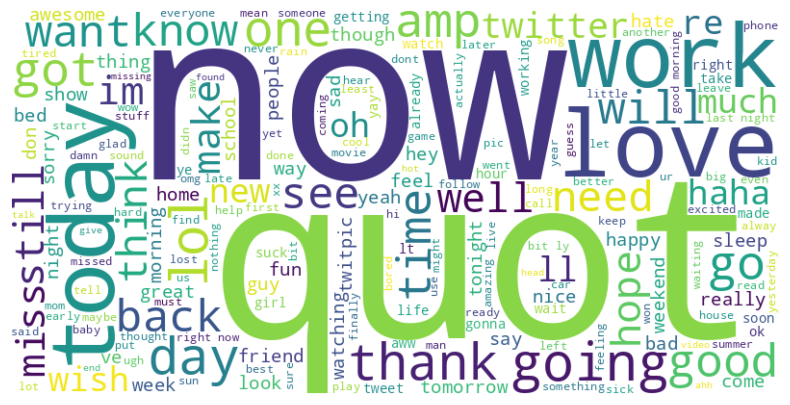

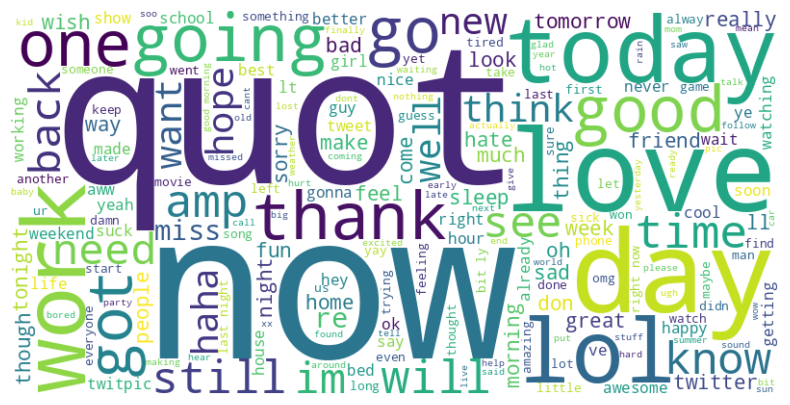

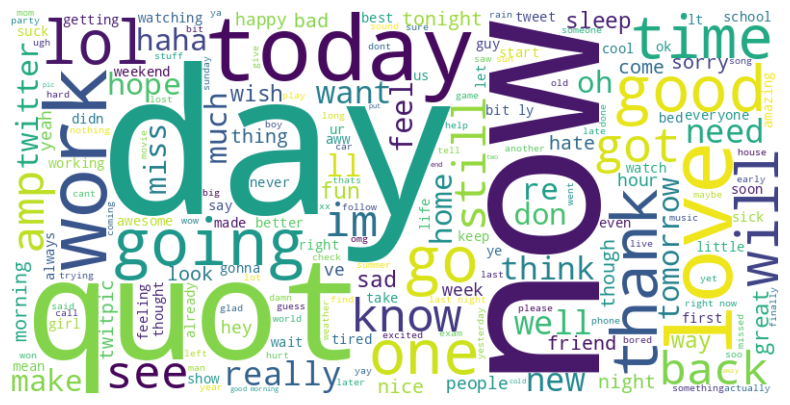

In [16]:
# Generate Word Cloud After Pre-Processing

text = " ".join(word for tokens in train_df['Text'] for word in tokens if word != "<number>")
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'train_word_cloud_after.png')
plt.show()

# Validation set word cloud
text = " ".join(word for tokens in val_df['Text'] for word in tokens if word != "<number>")
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'val_word_cloud_after.png')
plt.show()

# Test set word cloud
text = " ".join(word for tokens in test_df['Text'] for word in tokens if word != "<number>")
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(output_dir + 'test_word_cloud_after.png')
plt.show()

# **GLOVE VECTORIZER**

**glove.twitter.27B.200d**

In [17]:
# Build the vocabulary

vocab,embeddings = [],[]
with open('glove.twitter.27B.200d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

In [18]:
#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa, embs_npa))
print(embs_npa.shape)

# Create the embedding
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

# Confirm the embedding shape matches
assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

['<pad>' '<unk>' '<user>' '.' ':' 'rt' ',' '<repeat>' '<hashtag>'
 '<number>']
(1193516, 200)
torch.Size([1193516, 200])


In [19]:
# Convert text to indices, counting the number of OOV words
word2idx = {word: idx for idx, word in enumerate(vocab_npa)}

def text_to_indices(texts, word2idx, max_length=100):
    encoded = []
    oov_words = set()
    total_words = 0

    for text in texts:
        indices = []
        for word in text:
            total_words += 1
            if word in word2idx:
                indices.append(word2idx[word])
            else:
                indices.append(word2idx['<unk>'])
                oov_words.add(word)
        padded = indices[:max_length] + [word2idx['<pad>']] * (max_length - len(indices))
        encoded.append(padded)

    oov_df = pd.DataFrame({'OOV_Word': sorted(oov_words)})
    oov_df.to_csv('oov_words.csv', index=False)

    total_oov = len(oov_words)
    oov_percentage = (total_oov / total_words) * 100

    print(f"Total OOV words: {total_oov} our of Total Words: {total_words}")
    print(f"Percentage of OOV words: {oov_percentage:.2f}% \n")

    return np.array(encoded)

train_indices = text_to_indices(train_df['Text'], word2idx)
val_indices = text_to_indices(val_df['Text'], word2idx)
test_indices = text_to_indices(test_df['Text'], word2idx)


Total OOV words: 16653 our of Total Words: 1797300
Percentage of OOV words: 0.93% 

Total OOV words: 4885 our of Total Words: 513863
Percentage of OOV words: 0.95% 

Total OOV words: 2583 our of Total Words: 258593
Percentage of OOV words: 1.00% 



In [20]:
# Converting Tensors and Creating Dataloaders

BATCH_SIZE = 256

train_tensor = TensorDataset(
    torch.LongTensor(train_indices),
    torch.FloatTensor(train_df['Label'].values)
)

train_loader = DataLoader(
    train_tensor,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffle the training data
    num_workers=2
)

val_tensor = TensorDataset(
    torch.LongTensor(val_indices),
    torch.FloatTensor(val_df['Label'].values)
)

# Create DataLoader
val_loader = DataLoader(
    val_tensor,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_tensor = TensorDataset(torch.LongTensor(test_indices))

test_loader = DataLoader(
    test_tensor,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# **CREATE THE MODEL**

In [21]:
# Use a GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
# Feed Forward Neural Network

class FFNN(nn.Module):
    def __init__(self, embedding_layer):
        super().__init__()

        # Embeddnig Layer
        self.embedding = embedding_layer

        # Allow Fine Tuning
        self.embedding.weight.requires_grad = True

        # Layer 1: Embedding Dimension (200) -> 738
        self.fc1 = nn.Linear(self.embedding.embedding_dim, 738)
        self.bn1 = nn.BatchNorm1d(738)
        self.drop1 = nn.Dropout(p=0.18300243039826286)

        # Layer 2: 738 -> 446
        self.fc2 = nn.Linear(738, 446)
        self.bn2 = nn.BatchNorm1d(446)
        self.drop2 = nn.Dropout(p=0.4217747676930847)

        # Layer 3: 446 -> 178
        self.fc3 = nn.Linear(446, 178)
        self.bn3 = nn.BatchNorm1d(178)
        self.drop3 = nn.Dropout(p=0.08787363292289922)

        # Layer 4: 178 -> 89
        self.fc4 = nn.Linear(178, 89)
        self.bn4 = nn.BatchNorm1d(89)
        self.drop4 = nn.Dropout(p=0.1)

        # Final Output Layer: 89 -> 1
        self.fc5 = nn.Linear(89, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, sequence_length, embedding_dimension)
        x = torch.mean(x, dim=1)  # (batch_size, embedding_dimension)

        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.drop3(F.relu(self.bn3(self.fc3(x))))
        x = self.drop4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return torch.sigmoid(x)


model = FFNN(my_embedding_layer).to(device)

In [23]:
model

FFNN(
  (embedding): Embedding(1193516, 200)
  (fc1): Linear(in_features=200, out_features=738, bias=True)
  (bn1): BatchNorm1d(738, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.18300243039826286, inplace=False)
  (fc2): Linear(in_features=738, out_features=446, bias=True)
  (bn2): BatchNorm1d(446, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4217747676930847, inplace=False)
  (fc3): Linear(in_features=446, out_features=178, bias=True)
  (bn3): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.08787363292289922, inplace=False)
  (fc4): Linear(in_features=178, out_features=89, bias=True)
  (bn4): BatchNorm1d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=89, out_features=1, bias=True)
)

In [24]:
# Print the model in a PNG format

def text_to_png(text, filename, font_size=14):
    lines = text.split("\n")
    font = ImageFont.load_default()

    max_width = max([len(line) for line in lines]) * font_size // 2
    height = font_size * len(lines) + 20

    img = Image.new('RGB', (max_width, height), color='white')
    draw = ImageDraw.Draw(img)

    y = 10
    for line in lines:
        draw.text((10, y), line, fill='black', font=font)
        y += font_size

    img.save(filename)
    
model_string = str(model)
text_to_png(model_string, "model.png")

# **TRAIN AND VALIDATE THE MODEL**

In [25]:
# Optimiszer + Scheduler
epochs = 50

criterion = nn.BCELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=9.333913437212512e-05, betas=(0.95, 0.98), weight_decay=2.553254520434184e-05)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=5,
    threshold=0.001
)

In [26]:
# Calculate the accuracy

def accuracy(probs, labels):
    preds = (probs >= 0.5).long().squeeze()
    return (preds == labels.long()).sum().item()

In [27]:
# Validation and Training Loops

# Training function
def train_loop(model, train_loader, optimizer, criterion):
  model.train()
  train_accuracy = 0.0
  train_losses = []
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs).squeeze()
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_accuracy += accuracy(outputs, labels)

  epoch_train_loss = np.mean(train_losses)
  epoch_train_accuracy = (train_accuracy/len(train_loader.dataset)) * 100.0
  return (epoch_train_loss, epoch_train_accuracy)

# Validation function
def val_loop(model, val_loader, criterion):
  model.eval()
  val_accuracy = 0.0
  val_losses = []
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs).squeeze()
      loss = criterion(outputs, labels)

      val_losses.append(loss.item())
      val_accuracy += accuracy(outputs, labels)

  epoch_val_loss = np.mean(val_losses)
  epoch_val_accuracy = (val_accuracy/len(val_loader.dataset)) * 100.0

  return (epoch_val_loss, epoch_val_accuracy)

# Training and validation loop with Early Stopping Implementation
epoch_train_losses = []
epoch_train_accuracies = []
epoch_val_losses = []
epoch_val_accuracies = []

# Early stopping parameters
best_val_acc = 0.0
best_train_acc = 0.0
epochs_without_improvement = 0
patience = 5
best_model_weights = None

for epoch in range(epochs):
    epoch_train_loss, epoch_train_accuracy = train_loop(model, train_loader, optimizer, criterion)
    epoch_val_loss, epoch_val_accuracy = val_loop(model, val_loader, criterion)

    scheduler.step(epoch_val_accuracy)

    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        epochs_without_improvement = 0
        
        # Save a copy of the best model weights
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        epochs_without_improvement += 1

    if epoch_train_accuracy > best_train_acc:
      best_train_acc = epoch_train_accuracy

    epoch_train_losses.append(epoch_train_loss)
    epoch_train_accuracies.append(epoch_train_accuracy)
    epoch_val_losses.append(epoch_val_loss)
    epoch_val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f} Training Accuracy: {epoch_train_accuracy:.4f} | Validation Loss: {epoch_val_loss:.4f} Validation Accuracy: {epoch_val_accuracy:.4f}')

    # Early stopping check
    if epochs_without_improvement >= patience:
        print(f'\nEarly stopping triggered at epoch {epoch+1}')
        break

print(f"Best Training Accuracy is {best_train_acc:.4f}")
print(f"Best Validation Accuracy is {best_val_acc:.4f}")

Epoch 1/50, Training Loss: 0.5352 Training Accuracy: 72.4021 | Validation Loss: 0.4695 Validation Accuracy: 77.2408
Epoch 2/50, Training Loss: 0.4715 Training Accuracy: 77.3924 | Validation Loss: 0.4517 Validation Accuracy: 78.3376
Epoch 3/50, Training Loss: 0.4508 Training Accuracy: 78.7126 | Validation Loss: 0.4440 Validation Accuracy: 78.8801
Epoch 4/50, Training Loss: 0.4376 Training Accuracy: 79.5361 | Validation Loss: 0.4388 Validation Accuracy: 79.1796
Epoch 5/50, Training Loss: 0.4266 Training Accuracy: 80.2039 | Validation Loss: 0.4374 Validation Accuracy: 79.3943
Epoch 6/50, Training Loss: 0.4168 Training Accuracy: 80.8542 | Validation Loss: 0.4342 Validation Accuracy: 79.7056
Epoch 7/50, Training Loss: 0.4092 Training Accuracy: 81.1804 | Validation Loss: 0.4327 Validation Accuracy: 79.8684
Epoch 8/50, Training Loss: 0.4010 Training Accuracy: 81.7128 | Validation Loss: 0.4331 Validation Accuracy: 79.9557
Epoch 9/50, Training Loss: 0.3950 Training Accuracy: 82.0814 | Validatio

In [28]:
# Load the model with the best weights

model.load_state_dict(best_model_weights)
model.to(device)

FFNN(
  (embedding): Embedding(1193516, 200)
  (fc1): Linear(in_features=200, out_features=738, bias=True)
  (bn1): BatchNorm1d(738, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.18300243039826286, inplace=False)
  (fc2): Linear(in_features=738, out_features=446, bias=True)
  (bn2): BatchNorm1d(446, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4217747676930847, inplace=False)
  (fc3): Linear(in_features=446, out_features=178, bias=True)
  (bn3): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.08787363292289922, inplace=False)
  (fc4): Linear(in_features=178, out_features=89, bias=True)
  (bn4): BatchNorm1d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=89, out_features=1, bias=True)
)

In [29]:
# Scikit-Learn Classification Report

def get_predictions(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs >= 0.5).long().squeeze()

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

actual_labels, prediction_labels = get_predictions(model, val_loader)

print("\nClassification Report for Best Model:")
print(classification_report(actual_labels, prediction_labels, target_names=['Negative', 'Positive'], digits=5))


Classification Report for Best Model:
              precision    recall  f1-score   support

    Negative    0.80377   0.79615   0.79994     21197
    Positive    0.79808   0.80565   0.80185     21199

    accuracy                        0.80090     42396
   macro avg    0.80093   0.80090   0.80090     42396
weighted avg    0.80093   0.80090   0.80090     42396



# **SUBMIT THE MODEL TO KAGGLE**

In [30]:
# Submit the prediction to the competition

model.eval()

predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).long().squeeze()
        predictions.extend(preds.cpu().numpy())

# Create submission file
submission_df = pd.DataFrame({
    "ID": test_df["ID"],
    "Label": predictions
})
submission_df.to_csv("submission.csv", index=False)

print('Submission.csv has been uploaded')

Submission.csv has been uploaded


# MODEL ANALYSIS

In [31]:
# Calculate the Absolute Difference (Percentage) Between Training Score and Accuracy Score

absolute_difference = abs(best_train_acc - best_val_acc)

print(f"Training Accuracy: {best_train_acc:.5f}")
print(f"Validation Accuracy: {best_val_acc:.5f}")
print(f"\nAbsolute Difference (Percentage): {absolute_difference:.5f}%")

Training Accuracy: 84.16988
Validation Accuracy: 80.09010

Absolute Difference (Percentage): 4.07978%


# ROC CURVE

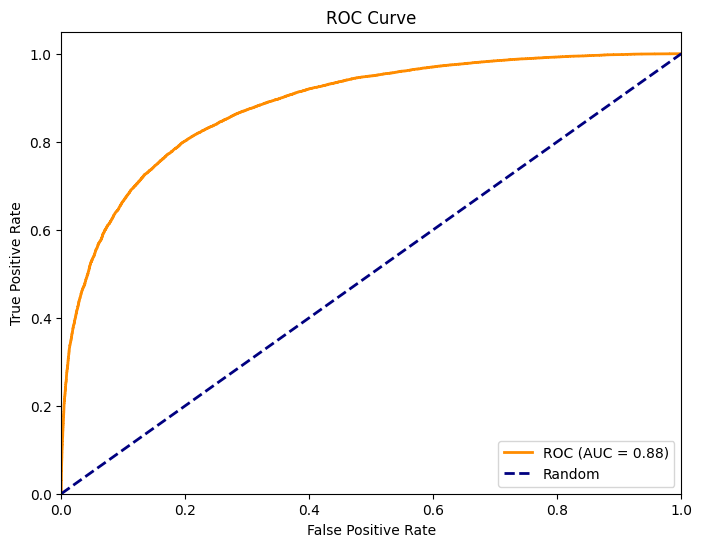

In [32]:
# Generate Receiver operating characteristic (ROC) Curve

def get_probabilities(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = outputs.squeeze().cpu()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

y_probs, y_true = get_probabilities(model, val_loader)

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# CONFUSION MATRIX

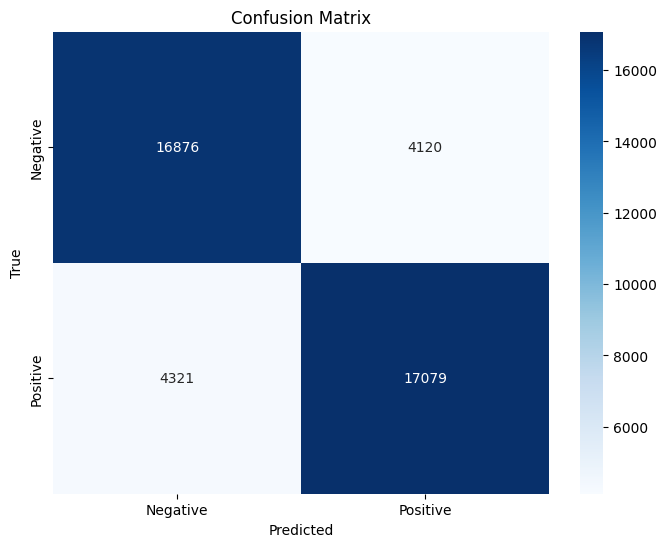

In [33]:
# Generate Confusion Matrix

y_pred, y_true = get_predictions(model, val_loader)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# LEARNING CURVE (ACCURACY)

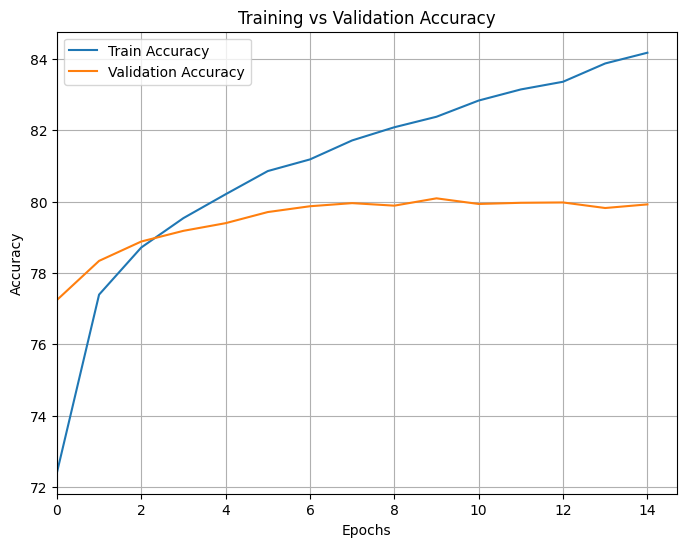

In [34]:
# Generate learning curve for Accuracy

plt.figure(figsize=(8, 6))
plt.plot(epoch_train_accuracies, label='Train Accuracy')
plt.plot(epoch_val_accuracies, label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xlim(left=0)
plt.grid()
plt.savefig('accuracy_learning_curve.png', bbox_inches='tight')
plt.show()

# LEARNING CURVE (LOSS)

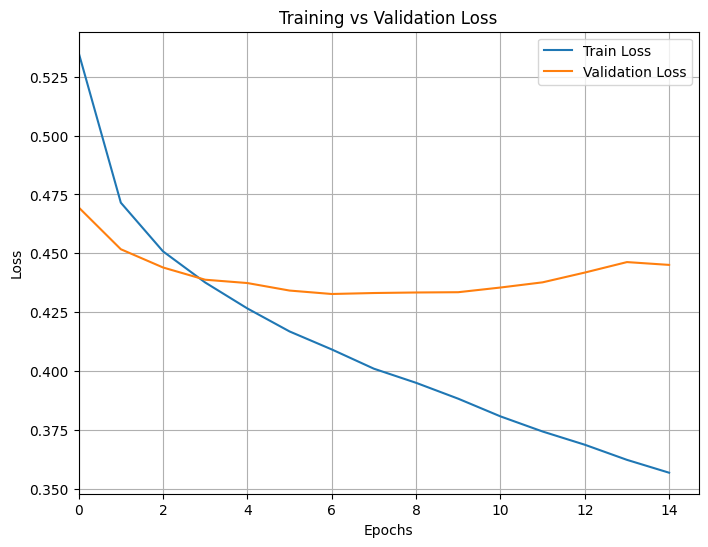

In [35]:
# Save Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(epoch_train_losses, label='Train Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.xlim(left=0)
plt.grid()
plt.savefig('loss_learning_curve.png', bbox_inches='tight')
plt.show()